<a href="https://colab.research.google.com/github/comaraDOTcom/ml-applications/blob/main/Etivity2/ET5003_Etivity2_CONOROMARA_20151845.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "" #@param {type:"string"}
Student_full_name = "" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Example' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [435]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")


# plot settings

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
sns.set_theme(context='notebook', style='ticks', palette='Accent', font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [436]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

In [437]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [438]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [439]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [440]:
path = '/content/drive/My Drive/Masters/ET5003_Enrique/etivity2/house_data/'

In [441]:
train_data = 'house_train.csv'
test_data = 'house_test.csv'
true_price = 'true_price.csv'

In [442]:
df_train = pd.read_csv(path+train_data)
df_test = pd.read_csv(path+test_data)
df_target = pd.read_csv(path + true_price)

### Train dataset

In [443]:
# show first data frame rows 
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [444]:
# Generate descriptive statistics
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [472]:
features = ['ad_id', 'bathrooms', 'beds', 'latitude', 'longitude', 'surface', 'price']

In [473]:
df_train_subset = df_train[features]
del features[-1]

In [474]:
# drop null price rows (drops 70 rows)
df_train_subset = df_train_subset[~df_train_subset['price'].isna()]

In [475]:
def show_nulls(df):
  nulls = pd.DataFrame(df.isna().sum())
  nulls.rename(columns = {0:'Number of Nulls'}, inplace = True) 
  nulls['% of Nulls'] = nulls['Number of Nulls']/df.shape[0]*100
  cols_with_nulls = nulls[nulls['Number of Nulls'] > 0].T.columns.tolist()
  return nulls

In [476]:
df_train_subset.shape

(2892, 7)

In [477]:
for i in features:
  df_train_subset[i].fillna(df_train_subset[i].median(), inplace=True)

In [478]:
# double check no nulls left
show_nulls(df_train_subset)

,Number of Nulls,% of Nulls
ad_id,0,0.0
bathrooms,0,0.0
beds,0,0.0
latitude,0,0.0
longitude,0,0.0
surface,0,0.0
price,0,0.0


In [479]:
#Look at outliers in long and latitude data
def plot_distribtion(df, feature):
    """
    Function plots the histogram and boxplot distribution of the feature side by side.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f'{feature}')
    sns.histplot(ax=ax1, data=df, x=feature, kde=True)
    sns.boxplot(ax=ax2,data=df,  y=feature, palette="Set2")
    plt.show()

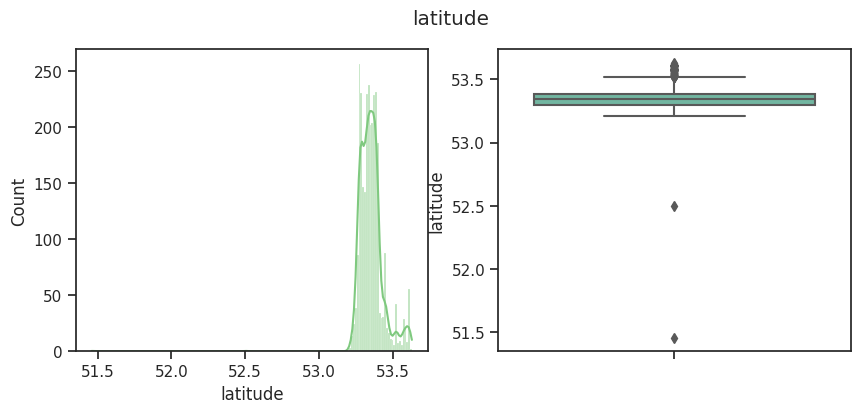

In [480]:
# lots of outliers exist in the longitudinal data
plot_distribtion(df_train_subset, 'latitude')

In [481]:
from matplotlib.cbook import boxplot_stats

outliers = [y for stat in boxplot_stats(df_train_subset['latitude']) for y in stat['fliers']]

In [482]:
#drop rows that contain any value outliers
df_train_subset = df_train_subset[df_train_subset.latitude.isin(outliers) == False]

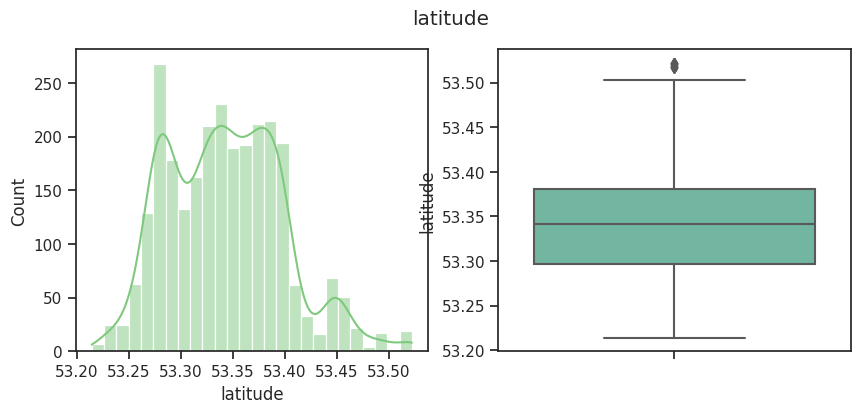

In [483]:
# plot again without outliers
plot_distribtion(df_train_subset, 'latitude')

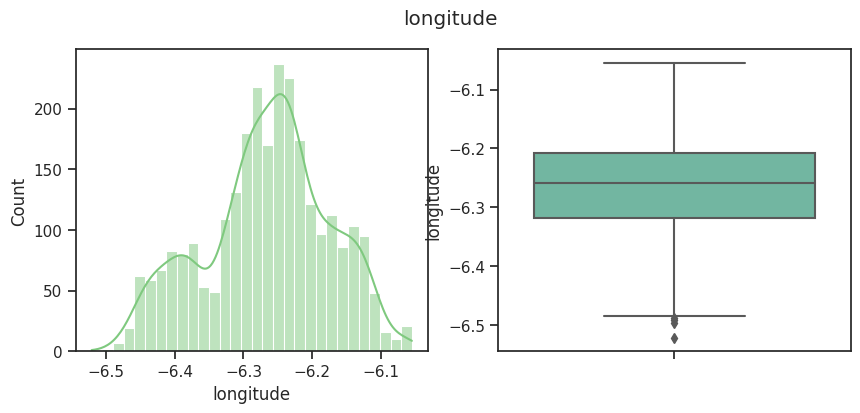

In [484]:
plot_distribtion(df_train_subset, 'longitude')

In [485]:
# no null data in the training data. Looks good to plot with.
df_test_subset = df_test[features]
print(f'Columns in df_test_subset: {df_test_subset.columns}')
show_nulls(df_test_subset)

Columns in df_test_subset: Index(['ad_id', 'bathrooms', 'beds', 'latitude', 'longitude', 'surface'], dtype='object')


,Number of Nulls,% of Nulls
ad_id,0,0.0
bathrooms,0,0.0
beds,0,0.0
latitude,0,0.0
longitude,0,0.0
surface,0,0.0


In [486]:
df_train_subset.head()

,ad_id,bathrooms,beds,latitude,longitude,surface,price
15,9124101,3.0,5.0,53.400454,-6.445730,321.0,935000.0
26,9135354,4.0,4.0,53.316410,-6.385214,144.0,485000.0
27,9135646,3.0,5.0,53.401414,-6.446634,321.0,935000.0
35,9150119,5.0,5.0,53.375377,-6.056749,312.0,1475000.0
38,9150125,2.0,2.0,53.372130,-6.338466,83.0,410000.0


In [487]:
df_test_subset.head()

,ad_id,bathrooms,beds,latitude,longitude,surface
0,12373510,2.0,4.0,53.566881,-6.101148,142.0
1,12422623,2.0,3.0,53.362992,-6.452909,114.0
2,12377408,3.0,4.0,53.454198,-6.262964,172.0
3,12420093,4.0,3.0,53.354402,-6.458647,132.4
4,12417338,1.0,3.0,53.336530,-6.393587,88.0


In [492]:
Xs_train = df_train_subset.iloc[:,1:-1].values 
# train set, output column, cost
ys_train = df_train_subset.iloc[:,-1].values.reshape(-1,1)   

# test set, input columns
Xs_test = df_test_subset.iloc[:,1:].values 
# test set, output column, cost
y_test = df_true_price.Expected.values

In [494]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

Xss_train = np.hstack([Xs_train,(Xs_train[:,[2]]*Xs_train[:,[3]])])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,(Xs_test[:,[2]]*Xs_test[:,[3]])])
Xn_test = xscaler.transform(Xss_test)

# how did we know how to do this?
ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

# PIECEWISE REGRESSION

## Full Model

In [495]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 2,861.2


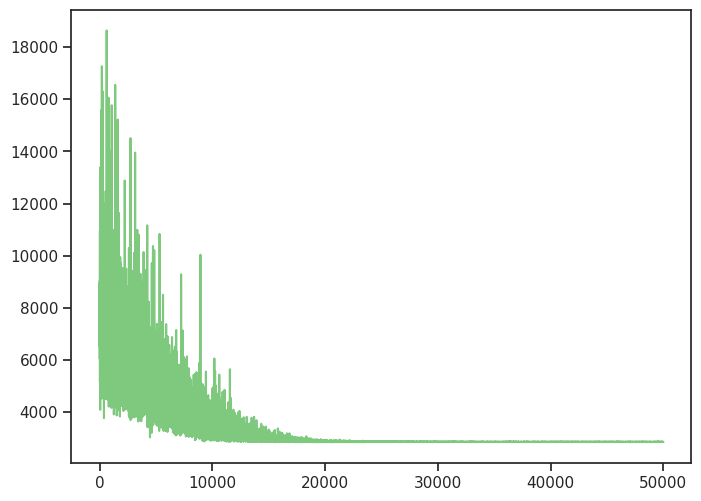

In [496]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

# samples from the posterior
posterior = approximation.sample(5000)

In [498]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
full_model_mae = np.mean(abs(y_pred_BLR - y_test))
full_model_mape = np.mean(abs(y_pred_BLR - y_test) / y_test)

print("Full model MAE = ",(full_model_mae))
print("Full model MAPE = ",(full_model_mape))

Full model MAE =  213072.54783837247
Full model MAPE =  0.28456529267495717


## Clustering

### Full Model

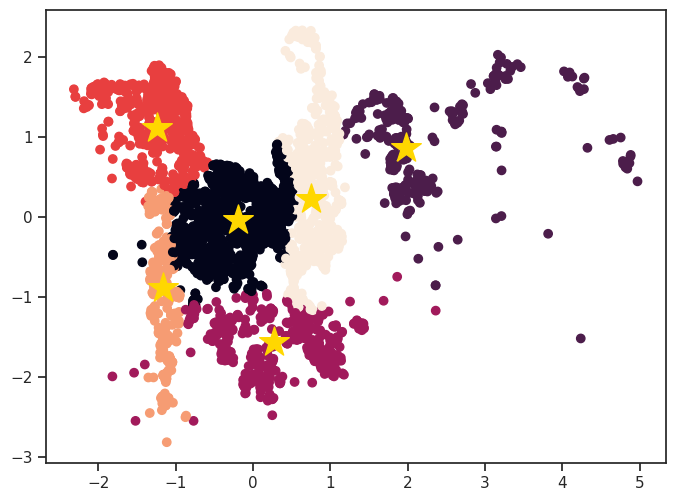

In [515]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=6)
# clustering by features 1, 2
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
labels = gmm.predict(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1], c = labels)
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1], c='gold', marker='*', s=500)
plt.show()

In [504]:
y_test.shape

(500,)

### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY